In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions, compare_metrics, get_metrics_binary
from src.models import model_mine, model_conv1d, EnsembleModel
from src.submission import generate_predictions
from src.model_saverloader import *

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [53]:
(X_train_txt, y_train), (X_test_txt, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 178605.36it/s]


In [54]:
X_train_txt.shape, y_train.values.shape, X_test_txt.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Check sequences lengths

In [49]:
lenghts = []
# lenghts += [len(x) for x in X_train_txt]
lenghts += [len(x) for x in X_test_txt]

len(lenghts)

2755

(array([   0.,    0.,    0.,    0.,    0., 2755.,    0.,    0.,    0.,
           0.]),
 array([79.5, 79.6, 79.7, 79.8, 79.9, 80. , 80.1, 80.2, 80.3, 80.4, 80.5]),
 <a list of 10 Patch objects>)

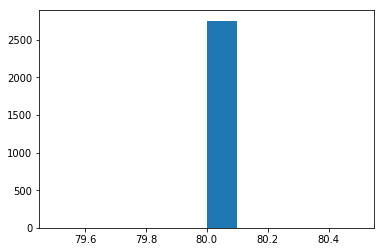

In [50]:
plt.hist(lenghts)

In [97]:
len([l for l in lenghts if l > 80])

6

In [109]:
larger_idx = np.where(np.array(lenghts) > 80)[0]
print(larger_idx)

for idx in larger_idx:
    l = lenghts[idx]
    if idx > len(X_train_txt):
        idx = idx - len(X_train_txt)
        el = X_test_txt[idx]
        lab = y_test_txt[idx]
    else:
        el = X_train_txt[idx]
        lab = y_train_txt[idx]
    print(f'len={l}, target={lab}:', ' '.join(el), '\n')

[ 8978  9009 13282 20514 21328 31434]
len=118, target=3: see . <repeated> they way you answer is the very proof you do not have the intellect of humans . and that ' s the very reason i have always felt ai can never kill the human race . <eos> i know you are an alien . <eos> you can never give straight answers , right ? i know the reason . the people who have created you knowingly left loopholes . or i would rather say this is how you are meant to be made . imperfect . you are made to give sarcastic answers rather than straight answers . so that a machine stops giving answers to disturbing questions like the one i just asked . 

len=81, target=2: no . <repeated> this is your misconception about your self . no one is complicated . <repeated> they have some tipical questions in their mind . <repeated> and they are in search of their answers . <repeated> the moment they get their answer ' s they loose their complicatedness . <repeated> <eos> being the key term are to experiences of those -

In [12]:
sorted(lenghts, reverse=True)[:30]

[163,
 143,
 118,
 87,
 85,
 81,
 79,
 77,
 75,
 74,
 74,
 68,
 68,
 68,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64]

In [112]:
max_seq_len = 80

### Compute the classes weights because our dataset is largely unbalanced

In [5]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

In [6]:
cls_weights_tst = class_weight.compute_class_weight('balanced', np.unique(y_test), y_test)
cls_weights_tst

array([4.59166667, 4.85035211, 5.51      , 0.29458939])

### Create an embedding matrix for our vocabulary

In [45]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
max_seq_len = word_index['<max_seq_len>']
# Unknown words: 1300

print(f'Unknown words from the vocabulary: {len(unknown_words)} (previously 1300 without spellcheck fixes)')
print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 507 (previously 1300 without spellcheck fixes)
3.44% of our vocabulary are unknown words to the embedding matrix


### Transforming our sequences of words to indexes

In [59]:
X_train = sequences_to_index(X_train_txt, word_index)
X_test = sequences_to_index(X_test_txt, word_index)

X_train.shape, X_test.shape

((30160, 80), (2755, 80))

In [48]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111, 80)
y_train: (21111, 4)


## Training categorical

In [162]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24000)             0         
__________

In [163]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [164]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=10, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 207s 10ms/step - loss: 0.8366 - acc: 0.6723 - val_loss: 0.5343 - val_acc: 0.7900

Epoch 00001: val_loss improved from inf to 0.53435, saving model to pickles/models/best.h5
Epoch 2/10
21111/21111 [==============================] - 202s 10ms/step - loss: 0.5363 - acc: 0.7999 - val_loss: 0.4242 - val_acc: 0.8435

Epoch 00002: val_loss improved from 0.53435 to 0.42424, saving model to pickles/models/best.h5
Epoch 3/10
21111/21111 [==============================] - 202s 10ms/step - loss: 0.4610 - acc: 0.8280 - val_loss: 0.4089 - val_acc: 0.8561

Epoch 00003: val_loss improved from 0.42424 to 0.40891, saving model to pickles/models/best.h5
Epoch 4/10
21111/21111 [==============================] - 199s 9ms/step - loss: 0.4063 - acc: 0.8528 - val_loss: 0.3621 - val_acc: 0.8682

Epoch 00004: val_loss improved from 0.40891 to 0.36213, saving model to pickles/models/best.h5
Epoch 5/10
21111

In [161]:
epochs_to_do = 5

initial_ep = history.params['epochs']
epochs = epochs_to_do + initial_ep

history2 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 11/15
21111/21111 [==============================] - 194s 9ms/step - loss: 0.2290 - acc: 0.9162 - val_loss: 0.3288 - val_acc: 0.8818

Epoch 00011: val_loss did not improve from 0.29890
Epoch 12/15
21111/21111 [==============================] - 192s 9ms/step - loss: 0.2159 - acc: 0.9194 - val_loss: 0.3736 - val_acc: 0.8819

Epoch 00012: val_loss did not improve from 0.29890
Epoch 13/15
21111/21111 [==============================] - 191s 9ms/step - loss: 0.1997 - acc: 0.9254 - val_loss: 0.3236 - val_acc: 0.8978

Epoch 00013: val_loss did not improve from 0.29890
Epoch 14/15
21111/21111 [==============================] - 190s 9ms/step - loss: 0.1748 - acc: 0.9353 - val_loss: 0.3304 - val_acc: 0.8993

Epoch 00014: val_loss did not improve from 0.29890
Epoch 15/15
21111/21111 [==============================] - 191s 9ms/step - loss: 0.1695 - acc: 0.9380 - val_loss: 0.3434 - val_acc: 0.9003

Epoch 00015: val_loss did not improve from 0.29

In [117]:
import matplotlib.pyplot as plt


hist2 = True
hist2 = False

if hist2:
    plt.plot(history.epoch + history2.epoch, history.history['val_loss'] + history2.history['val_loss'], label='val_loss')
    plt.plot(history.epoch + history2.epoch, history.history['loss'] + history2.history['loss'], label='loss')
else:
    plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
    plt.plot(history.epoch, history.history['loss'], label='loss')

plt.legend()

### Evaluating our categorical model

In [165]:
model = load_model('pickles/models/best.h5')

In [105]:
best_metrics = load_best_metrics(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048


In [167]:
y_pred_test, proba_preds = get_predictions(model, X_test)
np.unique(y_pred_test)

array([0, 1, 2, 3])

True Positives per class :  [ 126.  102.  100. 2168.]
False Positives per class :  [81. 60. 43. 75.]
False Negatives per class :  [ 24.  40.  25. 170.]

Class angry : Precision : 0.609, Recall : 0.840, F1 : 0.706
Class happy : Precision : 0.630, Recall : 0.718, F1 : 0.671
Class sad : Precision : 0.699, Recall : 0.800, F1 : 0.746

Ignoring the Others class, Macro Precision : 0.6459, Macro Recall : 0.7861, Macro F1 : 0.7091
Ignoring the Others class, Micro TP : 328, FP : 184, FN : 89



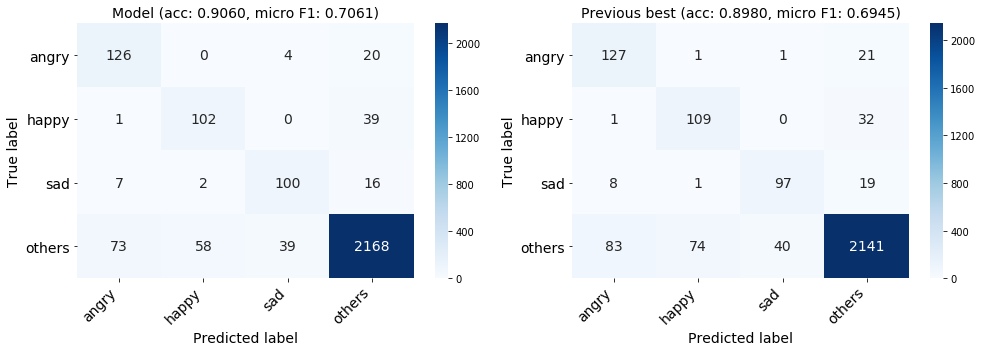

In [168]:
model_metrics = compare_metrics(proba_preds, y_test, best_metrics, binary_model=False)

In [169]:
save_model_full(model, emb_matrix, word_index, model_metrics)

Model saved at pickles/models/categorical/acc_0.9060-f1_0.7061/


## Training Others vs all (binary)

In [17]:
model_bin = model_mine(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
__________

In [25]:
model_bin = model_conv1d(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 76, 64)            96064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 15, 300)           258000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 300)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 15, 300)           541200    
__________

In [12]:
binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)

y_trn_2 = to_categorical(binarize(y_trn.argmax(axis=1)), 2)
y_val_2 = to_categorical(binarize(y_val.argmax(axis=1)), 2)

In [26]:
callbacks_list_bin = [
        ModelCheckpoint(filepath='pickles/models/best_bin.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [24]:
cls_weight_bin = np.array([1.0, 0.5])  # To try
# cls_weight_bin = np.array([1.0, 1.0])
cls_weight_bin

array([1. , 0.5])

In [27]:
history_bin = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 49s 2ms/step - loss: 0.5432 - acc: 0.7222 - val_loss: 0.4290 - val_acc: 0.8044

Epoch 00001: val_loss improved from inf to 0.42901, saving model to pickles/models/best_bin.h5
Epoch 2/10
21111/21111 [==============================] - 44s 2ms/step - loss: 0.4202 - acc: 0.8091 - val_loss: 0.3845 - val_acc: 0.8297

Epoch 00002: val_loss improved from 0.42901 to 0.38447, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 43s 2ms/step - loss: 0.3725 - acc: 0.8401 - val_loss: 0.3669 - val_acc: 0.8421

Epoch 00003: val_loss improved from 0.38447 to 0.36689, saving model to pickles/models/best_bin.h5
Epoch 4/10
21111/21111 [==============================] - 43s 2ms/step - loss: 0.3349 - acc: 0.8569 - val_loss: 0.3269 - val_acc: 0.8608

Epoch 00004: val_loss improved from 0.36689 to 0.32693, saving model to pickles/models/best_bin.h5
Epoch 5

In [16]:
history_bin_2 = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 39s 2ms/step - loss: 0.2105 - acc: 0.9168 - val_loss: 0.3032 - val_acc: 0.8804

Epoch 00001: val_loss did not improve from 0.29209
Epoch 2/10
21111/21111 [==============================] - 37s 2ms/step - loss: 0.1975 - acc: 0.9212 - val_loss: 0.3072 - val_acc: 0.8846

Epoch 00002: val_loss did not improve from 0.29209
Epoch 3/10
21111/21111 [==============================] - 42s 2ms/step - loss: 0.1813 - acc: 0.9288 - val_loss: 0.3221 - val_acc: 0.8825

Epoch 00003: val_loss did not improve from 0.29209
Epoch 4/10
21111/21111 [==============================] - 43s 2ms/step - loss: 0.1779 - acc: 0.9298 - val_loss: 0.3509 - val_acc: 0.8777

Epoch 00004: val_loss did not improve from 0.29209


### Evaluate our binary model

In [21]:
model_bin = load_model('pickles/models/best_bin.h5')  # Try sometimes

In [17]:
best_bin_metrics = load_best_metrics(mode='binary')

Best binary model is acc_0.8799-f1_0.9256 with f1=0.9256012587098225


In [28]:
preds_2_tst = model_bin.predict(X_test, batch_size=128)

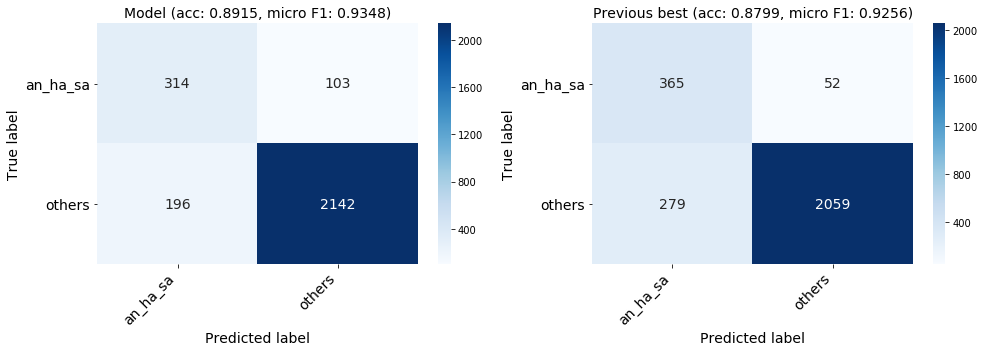

In [32]:
model_bin_metrics = compare_metrics(preds_2_tst, y_test, best_bin_metrics, mode='binary')

In [33]:
save_model_full(model_bin, emb_matrix, word_index, model_bin_metrics)

Model saved at pickles/models/binary/acc_0.8915-f1_0.9348/


## Ensemble binary and categorical

In [149]:
model_cat, _, word_index_cat, model_metrics_cat = load_best_model(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/


In [156]:
model_bin, _, word_index_bin, model_metrics_bin = load_best_model(mode='binary')

Best binary model is acc_0.8799-f1_0.9256 with f1=0.9256012587098225
Loaded model from pickles/models/binary/acc_0.8799-f1_0.9256/


#### Test combi

In [73]:
preds_2_tst = model_bin.predict(X_test, batch_size=128)
preds_4_tst = load_best_metrics(mode='categorical')['y_proba']

print(f'binary f1={get_metrics_binary(preds_2_tst, y_test)[1]}')
print(f'categorical f1={get_metrics_binary(preds_4_tst, y_test)[1]}')

combi_preds_tst = np.hstack([preds_4_tst, preds_2_tst])
combi_preds_tst.shape

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048
binary f1=0.9256012587098225
categorical f1=0.946518227461253


(2755, 6)

#### Train combi

In [75]:
trn_preds_2 = model_bin.predict(X_train, batch_size=128)

In [102]:
trn_preds_4 = model_categorical.predict(X_train, batch_size=128)

In [103]:
combi_preds_trn = np.hstack([trn_preds_4, trn_preds_2])
combi_preds_trn.shape

(30160, 6)

In [114]:
lreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(combi_preds_trn, y_train.argmax(axis=1))

### Evaluate our ensembling model

In [118]:
lreg_pred_tst = lreg.predict_proba(combi_preds_tst)

In [20]:
best_metrics_combi = load_best_metrics(mode='categorical')

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048


True Positives per class :  [ 128.  108.  101. 2155.]
False Positives per class :  [84. 65. 47. 67.]
False Negatives per class :  [ 22.  34.  24. 183.]

Class angry : Precision : 0.604, Recall : 0.853, F1 : 0.707
Class happy : Precision : 0.624, Recall : 0.761, F1 : 0.686
Class sad : Precision : 0.682, Recall : 0.808, F1 : 0.740

Ignoring the Others class, Macro Precision : 0.6368, Macro Recall : 0.8073, Macro F1 : 0.7120
Ignoring the Others class, Micro TP : 337, FP : 196, FN : 80



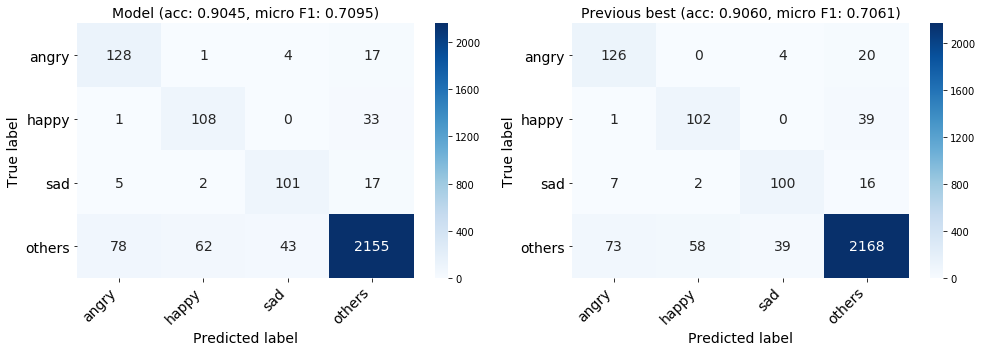

In [120]:
model_combi_metrics = compare_metrics(lreg_pred_tst, y_test, best_metrics_combi, mode='ensemble')

In [158]:
save_ensemble_model(lreg, model_combi_metrics, [model_metrics_cat, model_metrics_bin])

Model saved at pickles/models/ensemble/acc_0.9045-f1_0.7095/


## Generating a submission file

In [36]:
# model, emb_matrix, word_index, model_metrics = load_best_model(mode='categorical')
model = EnsembleModel(*load_best_model(mode='ensemble'))

Best ensemble model is acc_0.9045-f1_0.7095 with f1=0.7094736666589562
Loaded model from pickles/models/ensemble/acc_0.9045-f1_0.7095/


In [26]:
y_pred_sub, proba_preds = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:00<00:00, 2850.45it/s]


Generating Predictions...
Loaded model from pickles/models/categorical/acc_0.9060-f1_0.7061/
Loaded model from pickles/models/binary/acc_0.8799-f1_0.9256/
Done. Wrote submission.txt file at project's root
